# Inception v3

- Paper: [2015.12.02] Rethinking the Inception Architecture for Computer Vision
- https://arxiv.org/abs/1512.00567

### [Package load]

In [ ]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

### [Model: Inception v3]

- https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py
- https://velog.io/@krec7748/Inception-Net-v2-v3

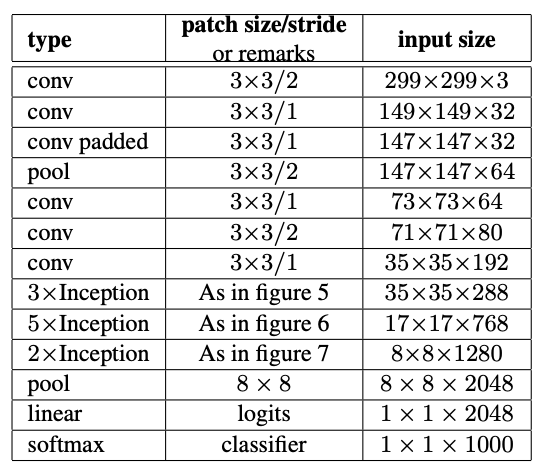

In [ ]:
class InceptionA(nn.Module):    # Figure 5에 해당, Inception module A
    def __init__(self, in_channels, pool_features, conv_block=None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch3x3_2 = conv_block(48, 64, kernel_size=3, padding=1)     # pytorch github에는 5x5로 되어 있어서 3x3으로 수정

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x):  # output이 list
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):    # 3x3으로 Grid size reduction하는 module
    def __init__(self, in_channels, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x):  # output이 list
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):    # 1x7, 7x1로 factorization하는 파트 (Figure 6) Inception module B
    def __init__(self, in_channels, channels_7x7, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):  # output이 list
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):    # Figure 10 : conv (stride 2) -> pooling operation
    def __init__(self, in_channels, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x):  # output이 list
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):    # Figure 7에 해당. Inception module C
    def __init__(self, in_channels, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):  # output이 list
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):  # Auxillary classifier
    def __init__(self, in_channels, num_classes, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01  # type: ignore[assignment]
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001  # type: ignore[assignment]

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


from collections import namedtuple
InceptionOutputs = namedtuple("InceptionOutputs", ["logits", "aux_logits"])

class InceptionV3(nn.Module):
    def __init__(self, num_classes, aux_logits= True, inception_blocks=None, dropout=0.5):
        super().__init__()
        if inception_blocks is None:
            inception_blocks = [BasicConv2d, InceptionA, InceptionB, InceptionC, InceptionD, InceptionE, InceptionAux]
        if len(inception_blocks) != 7:
            raise ValueError(f"length of inception_blocks should be 7 instead of {len(inception_blocks)}")
        
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]   # Fig 5, Inception module A
        inception_b = inception_blocks[2]   # Grid 축소
        inception_c = inception_blocks[3]   # Fig 6, Inception module B
        inception_d = inception_blocks[4]   # Fig 10, Grid 축소
        inception_e = inception_blocks[5]   # Fig 7, Inception module C
        inception_aux = inception_blocks[6] # Auxilary classifier

        self.aux_logits = aux_logits
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)     # ( 3, 299, 299) -> (32, 149, 149)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)              # (32, 149, 149) -> (32, 147, 147)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)   # (32, 147, 147) -> (64, 147, 147)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)               # (64, 147, 147) -> (64,  73,  73)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)              # (64,  73,  73) -> (80,  73,  73)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)             # (80,  73,  73) -> (192, 71,  71)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)               # (192, 71,  71) -> (192, 35,  35)
        
        # InceptionA(in_channels, pool_features, conv_block=None): Fig 5, Inception module A
        self.Mixed_5b = inception_a(192, pool_features=32)  # output channel = 64 + 64 + 96 + pool_fatures = 256
                                                            # (192, 35, 35) -> (256, 35, 35)
        self.Mixed_5c = inception_a(256, pool_features=64)  # (256, 35, 35) -> (256, 35, 35)
        self.Mixed_5d = inception_a(288, pool_features=64)  # (256, 35, 35) -> (288, 35, 35)

        # InceptionB(in_channels, conv_block = None): Grid 축소
        self.Mixed_6a = inception_b(288)                    # output channel = 384 + 96 + 288 = 768
                                                            # (288, 35, 35) -> (768, 17, 17)
        
        # InceptionC(in_channels, channels_7x7, conv_block = None): Fig 6, Inception module B
        self.Mixed_6b = inception_c(768, channels_7x7=128)  # (768, 17, 17) -> (768, 17, 17) channels_7x7만 계속 달라짐
        self.Mixed_6c = inception_c(768, channels_7x7=160)  # (768, 17, 17) -> (768, 17, 17)
        self.Mixed_6d = inception_c(768, channels_7x7=160)  # (768, 17, 17) -> (768, 17, 17)
        self.Mixed_6e = inception_c(768, channels_7x7=192)  # (768, 17, 17) -> (768, 17, 17)

        # InceptionAux(in_channels, num_classes, conv_block = None): Auxilary classifier
        self.AuxLogits = None
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        
        # InceptionD(in_channels, conv_block = None): Fig 10, Grid 축소
        self.Mixed_7a = inception_d(768)

        # InceptionE(in_channels, conv_block = None): Fig 7, Inception module C
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2048, num_classes)

    def _forward(self, x):
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux = None
        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

    def forward(self, x):
        x, aux = self._forward(x)
        return InceptionOutputs(x, aux)

In [ ]:
inception_v3 = InceptionV3(num_classes=4).to(device)

In [ ]:
inception_v3

InceptionV3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), str

In [ ]:
temp = torch.Tensor(np.random.randint(1, 255, size=(2, 3, 299, 299)))
print(inception_v3(temp))

InceptionOutputs(logits=tensor([[-0.2163, -0.0754,  0.3572,  0.1165],
        [-0.2836,  0.3130,  0.3749,  0.1114]], grad_fn=<AddmmBackward0>), aux_logits=tensor([[ 0.4885, -0.1306, -0.0032,  0.0319],
        [ 0.7105, -0.1515, -1.0155, -0.5032]], grad_fn=<AddmmBackward0>))


In [ ]:
from torchsummary import summary
summary(inception_v3, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
from torchinfo import summary
summary(inception_v3, input_size=(1, 3, 299, 299), col_width=20, depth=121, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                  Input Shape          Kernel Shape         Output Shape         Param %
InceptionV3 (InceptionV3)                          [1, 3, 299, 299]     --                   [1, 4]                10.58%
├─BasicConv2d (Conv2d_1a_3x3): 1-1                 [1, 3, 299, 299]     --                   [1, 32, 149, 149]         --
│    └─Conv2d (conv): 2-1                          [1, 3, 299, 299]     [3, 3]               [1, 32, 149, 149]      0.00%
│    └─BatchNorm2d (bn): 2-2                       [1, 32, 149, 149]    --                   [1, 32, 149, 149]      0.00%
├─BasicConv2d (Conv2d_2a_3x3): 1-2                 [1, 32, 149, 149]    --                   [1, 32, 147, 147]         --
│    └─Conv2d (conv): 2-3                          [1, 32, 149, 149]    [3, 3]               [1, 32, 147, 147]      0.04%
│    └─BatchNorm2d (bn): 2-4                       [1, 32, 147, 147]    --                   [1, 32, 147, 147]      0.00%
├─BasicConv2d (Conv2d_2b

### [Model: Inception v3 Transfer Learning]

In [ ]:
from collections import namedtuple
InceptionOutputs = namedtuple("InceptionOutputs", ["logits", "aux_logits"])

class TransferInceptionV3(nn.Module):
    def __init__ (self, num_classes, aux_logits=True):
        super(TransferInceptionV3, self).__init__()
        self.inception = torchvision.models.inception_v3(pretrained=True)
        aux_in_feature = self.inception.AuxLogits.fc.in_features
        self.inception.AuxLogits.fc = nn.Linear(aux_in_feature, num_classes)
        final_in_feature = self.inception.fc.in_features
        self.inception.fc = nn.Linear(final_in_feature, num_classes)
        
    def forward(self,x):
        return self.inception(x)

In [ ]:
inception_transfer = TransferInceptionV3(num_classes=4).to(device)

In [ ]:
temp = torch.Tensor(np.random.randint(1, 255, size=(2, 3, 299, 299)))
inception_transfer(temp)

InceptionOutputs(logits=tensor([[-0.2118,  0.2779, -0.3961, -0.2715],
        [ 0.0237,  0.3636, -0.2318,  0.3113]], grad_fn=<AddmmBackward0>), aux_logits=tensor([[ 0.0975,  0.3704, -0.5544, -0.5060],
        [-1.0842,  0.7955,  0.4740, -0.0754]], grad_fn=<AddmmBackward0>))

In [ ]:
inception_transfer

TransferInceptionV3(
  (inception): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a

In [ ]:
from torchsummary import summary
summary(inception_transfer, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
from torchinfo import summary
summary(inception_transfer, input_size=(2, 3, 299, 299), col_width=20, depth=1000, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                       Input Shape          Kernel Shape         Output Shape         Param %
TransferInceptionV3 (TransferInceptionV3)               [2, 3, 299, 299]     --                   [2, 4]                    --
├─Inception3 (inception): 1-1                           [2, 3, 299, 299]     --                   [2, 4]                10.51%
│    └─BasicConv2d (Conv2d_1a_3x3): 2-1                 [2, 3, 299, 299]     --                   [2, 32, 149, 149]         --
│    │    └─Conv2d (conv): 3-1                          [2, 3, 299, 299]     [3, 3]               [2, 32, 149, 149]      0.00%
│    │    └─BatchNorm2d (bn): 3-2                       [2, 32, 149, 149]    --                   [2, 32, 149, 149]      0.00%
│    └─BasicConv2d (Conv2d_2a_3x3): 2-2                 [2, 32, 149, 149]    --                   [2, 32, 147, 147]         --
│    │    └─Conv2d (conv): 3-3                          [2, 32, 149, 149]    [3, 3]               [2, 32, 147, 

In [ ]:
count = 0
for name, param in inception_transfer.inception.named_parameters():
    count += 1
    print(f"count:{count},",name, param.requires_grad)

count:1, Conv2d_1a_3x3.conv.weight True
count:2, Conv2d_1a_3x3.bn.weight True
count:3, Conv2d_1a_3x3.bn.bias True
count:4, Conv2d_2a_3x3.conv.weight True
count:5, Conv2d_2a_3x3.bn.weight True
count:6, Conv2d_2a_3x3.bn.bias True
count:7, Conv2d_2b_3x3.conv.weight True
count:8, Conv2d_2b_3x3.bn.weight True
count:9, Conv2d_2b_3x3.bn.bias True
count:10, Conv2d_3b_1x1.conv.weight True
count:11, Conv2d_3b_1x1.bn.weight True
count:12, Conv2d_3b_1x1.bn.bias True
count:13, Conv2d_4a_3x3.conv.weight True
count:14, Conv2d_4a_3x3.bn.weight True
count:15, Conv2d_4a_3x3.bn.bias True
count:16, Mixed_5b.branch1x1.conv.weight True
count:17, Mixed_5b.branch1x1.bn.weight True
count:18, Mixed_5b.branch1x1.bn.bias True
count:19, Mixed_5b.branch5x5_1.conv.weight True
count:20, Mixed_5b.branch5x5_1.bn.weight True
count:21, Mixed_5b.branch5x5_1.bn.bias True
count:22, Mixed_5b.branch5x5_2.conv.weight True
count:23, Mixed_5b.branch5x5_2.bn.weight True
count:24, Mixed_5b.branch5x5_2.bn.bias True
count:25, Mixed_

In [ ]:
# Auxiliary logit + 이전 6e inception module (181 ~ 218) / Fc layer + 이전 7b, 7c inception module (237~292)
count = 0
for param in inception_transfer.inception.parameters():
    count += 1
    if (181 <= count and count <= 218):
        param.requires_grad = True
    elif (237 <= count and count <= 292):
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in inception_transfer.inception.named_parameters():
    print(name, param.requires_grad)

Conv2d_1a_3x3.conv.weight False
Conv2d_1a_3x3.bn.weight False
Conv2d_1a_3x3.bn.bias False
Conv2d_2a_3x3.conv.weight False
Conv2d_2a_3x3.bn.weight False
Conv2d_2a_3x3.bn.bias False
Conv2d_2b_3x3.conv.weight False
Conv2d_2b_3x3.bn.weight False
Conv2d_2b_3x3.bn.bias False
Conv2d_3b_1x1.conv.weight False
Conv2d_3b_1x1.bn.weight False
Conv2d_3b_1x1.bn.bias False
Conv2d_4a_3x3.conv.weight False
Conv2d_4a_3x3.bn.weight False
Conv2d_4a_3x3.bn.bias False
Mixed_5b.branch1x1.conv.weight False
Mixed_5b.branch1x1.bn.weight False
Mixed_5b.branch1x1.bn.bias False
Mixed_5b.branch5x5_1.conv.weight False
Mixed_5b.branch5x5_1.bn.weight False
Mixed_5b.branch5x5_1.bn.bias False
Mixed_5b.branch5x5_2.conv.weight False
Mixed_5b.branch5x5_2.bn.weight False
Mixed_5b.branch5x5_2.bn.bias False
Mixed_5b.branch3x3dbl_1.conv.weight False
Mixed_5b.branch3x3dbl_1.bn.weight False
Mixed_5b.branch3x3dbl_1.bn.bias False
Mixed_5b.branch3x3dbl_2.conv.weight False
Mixed_5b.branch3x3dbl_2.bn.weight False
Mixed_5b.branch3x3dbl

In [ ]:
# 7b inception module의 Conv layer를 다시 initialization
name_list=[]
for name, param in inception_transfer.inception.Mixed_7b.named_parameters():
    name_list = name.split('.')
    if name_list[1]=='conv':
        if name_list[2]=='weight':
            print(name)
            nn.init.xavier_uniform_(param)
            print(name+'의 conv filter initialization setting 완료')
            print()

# 7c inception module의 Conv layer를 다시 initialization
name_list=[]
for name, param in inception_transfer.inception.Mixed_7c.named_parameters():
    name_list = name.split('.')
    if name_list[1]=='conv':
        if name_list[2]=='weight':
            print(name)
            nn.init.xavier_uniform_(param)
            print(name+'의 conv filter initialization setting 완료')
            print()

branch1x1.conv.weight
branch1x1.conv.weight의 conv filter initialization setting 완료

branch3x3_1.conv.weight
branch3x3_1.conv.weight의 conv filter initialization setting 완료

branch3x3_2a.conv.weight
branch3x3_2a.conv.weight의 conv filter initialization setting 완료

branch3x3_2b.conv.weight
branch3x3_2b.conv.weight의 conv filter initialization setting 완료

branch3x3dbl_1.conv.weight
branch3x3dbl_1.conv.weight의 conv filter initialization setting 완료

branch3x3dbl_2.conv.weight
branch3x3dbl_2.conv.weight의 conv filter initialization setting 완료

branch3x3dbl_3a.conv.weight
branch3x3dbl_3a.conv.weight의 conv filter initialization setting 완료

branch3x3dbl_3b.conv.weight
branch3x3dbl_3b.conv.weight의 conv filter initialization setting 완료

branch_pool.conv.weight
branch_pool.conv.weight의 conv filter initialization setting 완료

branch1x1.conv.weight
branch1x1.conv.weight의 conv filter initialization setting 완료

branch3x3_1.conv.weight
branch3x3_1.conv.weight의 conv filter initialization setting 완료

branch3x

In [ ]:
# 7b, 7c inception module의 batch normalization gamma, beta initialization
# Residual block이 없으니 모두 1로 initialization, beta는 0으로 initialization
name_list=[]
for name, param in inception_transfer.inception.Mixed_7b.named_parameters():
    name_list = name.split('.')
    if name_list[1]=='bn':
        if name_list[2]=='weight':
            print(name)
            nn.init.ones_(param)
            print(name+'의 gamma one setting 완료')
            print()
        elif name_list[2]=='bias':
            print(name)
            nn.init.zeros_(param)
            print(name+'의 beta zero setting 완료')
            print()

name_list=[]
for name, param in inception_transfer.inception.Mixed_7c.named_parameters():
    name_list = name.split('.')
    if name_list[1]=='bn':
        if name_list[2]=='weight':
            print(name)
            nn.init.ones_(param)
            print(name+'의 gamma one setting 완료')
            print()
        elif name_list[2]=='bias':
            print(name)
            nn.init.zeros_(param)
            print(name+'의 beta zero setting 완료')
            print()

branch1x1.bn.weight
branch1x1.bn.weight의 gamma one setting 완료

branch1x1.bn.bias
branch1x1.bn.bias의 beta zero setting 완료

branch3x3_1.bn.weight
branch3x3_1.bn.weight의 gamma one setting 완료

branch3x3_1.bn.bias
branch3x3_1.bn.bias의 beta zero setting 완료

branch3x3_2a.bn.weight
branch3x3_2a.bn.weight의 gamma one setting 완료

branch3x3_2a.bn.bias
branch3x3_2a.bn.bias의 beta zero setting 완료

branch3x3_2b.bn.weight
branch3x3_2b.bn.weight의 gamma one setting 완료

branch3x3_2b.bn.bias
branch3x3_2b.bn.bias의 beta zero setting 완료

branch3x3dbl_1.bn.weight
branch3x3dbl_1.bn.weight의 gamma one setting 완료

branch3x3dbl_1.bn.bias
branch3x3dbl_1.bn.bias의 beta zero setting 완료

branch3x3dbl_2.bn.weight
branch3x3dbl_2.bn.weight의 gamma one setting 완료

branch3x3dbl_2.bn.bias
branch3x3dbl_2.bn.bias의 beta zero setting 완료

branch3x3dbl_3a.bn.weight
branch3x3dbl_3a.bn.weight의 gamma one setting 완료

branch3x3dbl_3a.bn.bias
branch3x3dbl_3a.bn.bias의 beta zero setting 완료

branch3x3dbl_3b.bn.weight
branch3x3dbl_3b.bn.weigh